# The Daubechies D4 Wavelet Tranform

In [318]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt


def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))


def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        if details is not None:
            normalized = np.copy(result_V)
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])

                aP,cH,cV,cD = split_matrix(normalized)
                normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            normalized = np.copy(result_V)
            aP,cH,cV,cD = split_matrix(normalized)
            normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))

            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"The scale value has to be between 1 - {np.log2(width//4)}")
        


root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [319]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        normalized = np.copy(result_V)
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}"); return np.ones_like(image), np.ones_like(image)

In [320]:
def new_matrix(matriz, pix):
    n = len(matriz)
    nueva_matriz = matriz[:pix, :pix]
    
    return nueva_matriz

def concatenar(matriz_grande, matriz_pequena):
    n = len(matriz_pequena)
    matriz_grande[:n, :n] = matriz_pequena
    
    return matriz_grande

aux = 0

def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width, details = None):

    if (scale == 1) :

        daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
        result_H = np.dot(daubechies_coeffs_transpose, transform_result)

        image = []
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_aprox = width // (2 ** scale)
        tam_img = tam_aprox * 2
        new_img = new_matrix(transform_result, (tam_img))
        scale = scale - 1

        daubechies_coeffs_transpose = np.transpose(function_daubechies_coeffs(new_img))
        result_H = np.dot(daubechies_coeffs_transpose, new_img)

        image = []
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)

       
        image = concatenar(transform_result,image)

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(image),image,scale,len(image))



In [321]:
def zeros(image, scale):
    width = len(image)
    tam_aprox = width // (2 ** scale)
    tam_img = tam_aprox * 2

    image[:tam_img, :tam_img] = np.zeros((tam_img, tam_img))
    return image



## NUMERICS EXAMPLE

In [322]:
example = np.random.randint(0.0, 52.0, (16, 16))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")


Coeffs Matrix:
 [[ 0.483   0.8365  0.2241 -0.1294  0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.483   0.8365  0.2241 -0.1294  0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.483   0.8365  0.2241 -0.1294  0.
   0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.483   0.8365  0.2241
  -0.1294  0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.483
   0.8365  0.2241 -0.1294  0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.483   0.8365  0.2241 -0.1294  0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.483   0.8365  0.2241 -0.1294]
 [ 0.2241 -0.1294  0.      0.      0.      0.      0.      0.      0.
   

In [323]:
print(f"Original Matrix:\n {example}\n")
aP,cH,cV,cD = split_matrix(example)

dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,2,example.shape[0])
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,2,dwt.shape[0])
print(f"\n {np.round(dwt,0)}")
print(f"\n {np.round(idwt,0)}")

Original Matrix:
 [[42 46 11 14  3 39 32 39 45  3 19 38 49 34 26 12]
 [39  9 41 32 37 27 12 37 43 10 23  0 27  8 32 35]
 [20 13 45  7 12 14 18  1 19 21 38  4  6 40 42 48]
 [29  2 36  4  5  6 44 19 27 44 10 30 40 16 24 27]
 [36 48 39 40  7 20  7 14 29 43 17 49 50  7 41 12]
 [ 6 51  8 28 21 21 33  4 19  5 19  5 11  1 18 50]
 [18  9 28 40  1 35 26 27 13 41  9 24  5 26 28 48]
 [ 1 19 29 11  6  3 12  4 28 33 10 11 25  9 27 32]
 [13 44 45  3  6  5  2 18  7 51 47 26 42 34 22 14]
 [ 9 12 30 20 21 20 33 32  0 25 16  7 39 29 27 16]
 [40 11  8 40  8 36 41 25 32  6 29 11 28 25 27  6]
 [28  0 37 47 42 41 23  7  6 34 35 35 40 36 28 10]
 [ 6  8 12 30 20 35 38 26 26 25 33 26  1 24 20 14]
 [28 49 51 11 37 33 48 31 31 42 25  3 29 17 23 45]
 [28  0 14 49  8 50 41 41 43 21 19  2 18 40 27  4]
 [49 24 39 17 17  4 43  9 36  8 34  6 25 30 34 40]]


 [[ 59.  53.  52.  63.  42.  36.  50.  65.   7.  -6. -17.  31.  13.  13.
    6.  14.]
 [ 42.  39.  23.  37.  66.  51.  56.  66.  36. -10.  22.  -7. -12.  10.
    6

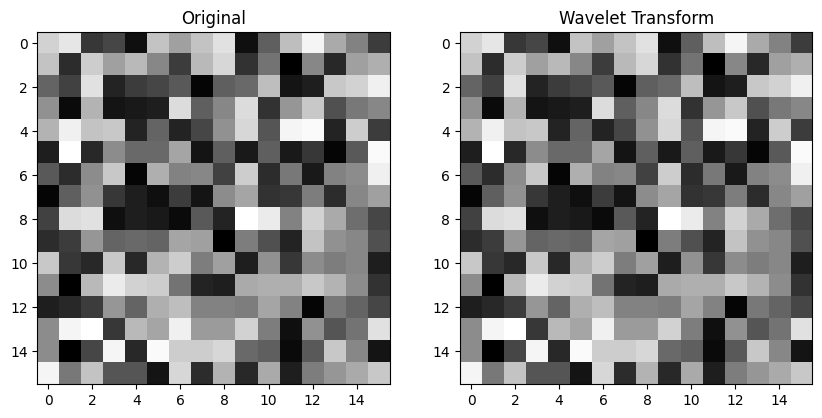

In [324]:
# imshow(np.concatenate((example,idwt), axis = 1))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(example, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((idwt), cmap='gray')
ax[1].set_title('Wavelet Transform')
plt.show()

## IMAGES EXAMPLES

In [325]:
photo = 'imagen.jpg'

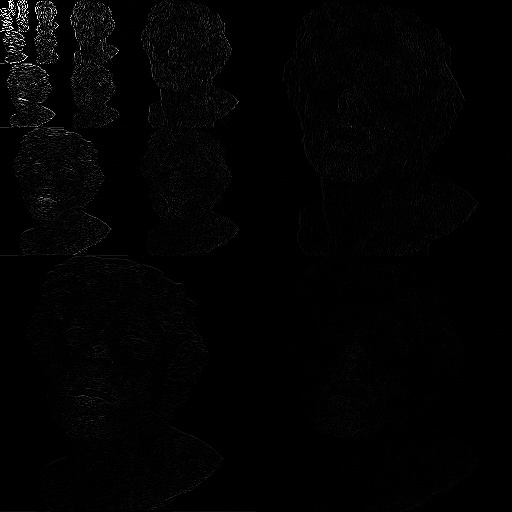

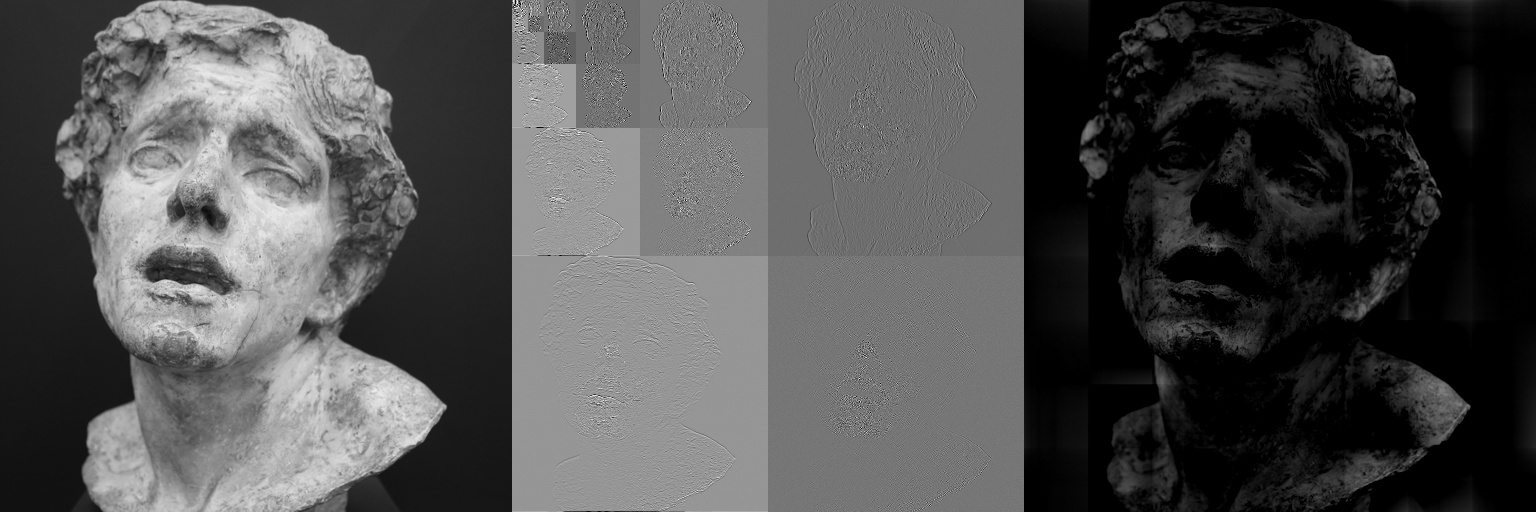

In [333]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 7, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
result_img = zeros(result_img, scale)
imshow(result_img)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,(scale),width)

imshow(np.concatenate((array_photo,normalized, reconstructed), axis = 1))


# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(array_photo, cmap='gray')
# ax[0].set_title('Original')
# ax[1].imshow((normalized), cmap='gray')
# ax[1].set_title('Wavelet Transform')
# plt.show()